### Readability: 
write a job that computes Gunning Fog Index and Flesch-Kincaid Readability (both reading ease and grade level) of user comments. Then:

Choose a subreddit and plot the distribution of these scores.
Choose two subreddits focused on similar topics but with different views, e.g., /r/apple and /r/android. Use these metrics to compare the populations from both.

In [65]:
topic = 'obama'
topic1 = 'apple'
topic2 = 'google'
topic3 = 'samsung'

### Gunning Fog Index
gunning-fox index = 0.4((words/sentences)+ 100(complex words/words))

### Flesch-Kincaid
#### Flesch reading ease
reading-ease score = 206.35 - 1.015(total words/total sentences) - 84.6(total syllables/total words)
Scores can be interpreted as shown in the table below.

Score	        School level	     Notes
100.00–90.00	5th grade	     Very easy to read. Easily understood by an average 11-year-old student.
90.0–80.0	    6th grade	     Easy to read. Conversational English for consumers.
80.0–70.0	    7th grade	     Fairly easy to read.
70.0–60.0	  8th & 9th grade	 Plain English. Easily understood by 13- to 15-year-old students.
60.0–50.0	 10th to 12th grade	 Fairly difficult to read.
50.0–30.0	     College	     Difficult to read.
30.0–0.0	  College graduate	 Very difficult to read. Best understood by university graduates.

#### Flesch–Kincaid grade level
grade-level = 0.39(total words/total sentences) + 11.8(total syllables/total words) - 15.59

#### Loading dataset 

In [57]:
# from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import from_json, col
conf = SparkConf().setAppName('FirstSpark2').setMaster('Spark')
sc = SparkContext.getOrCreate()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
df = sqlContext.read.json("hdfs://orion11:20001/sample_sampled_reddit/")

print(type(df))
print(df.count())

<class 'pyspark.sql.dataframe.DataFrame'>
30926243


#### Filtering dataset

In [58]:
df2 = df.filter(
~(df.body.like('[deleted]'))
    & ~(df.body.isNull())
    & ~(df.author.like('[deleted]'))
    & ~(df.author.like('AutoModerator')) 
    & ~(df.author.rlike("[bB][oO][tT]"))

)

# print(type(df2))
print(df2.count())
# df2.show(1)

27303462


#### Creating a view

In [4]:
%%time
df2.createOrReplaceTempView("dataframe")

CPU times: user 461 µs, sys: 1.1 ms, total: 1.56 ms
Wall time: 280 ms


#### Creating dataframe from the view

In [6]:
df3 = spark.sql('SELECT * from dataframe')

# print(type(df3))
# print(df3.count())
# df3.show(1)

#### Gunning Fog Index
gunning-fox index = 0.4((words/sentences)+ 100(complex words/words))

In [59]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *
import re

#getting 
def syllables(word):
    return sum(list(map(lambda x: 1 if x in ["a","i","e","o","u","y","A","E","I","O","U","y"] else 0,word)))


#getting the syllable count
def syllable_count(text):
    syllablecount = 0
    beg_each_Sentence = re.findall(r"\.\s*(\w+)", text)
    capital_words = re.findall(r"\b[A-Z][a-z]+\b", text)
    words = text.split()
    for word in words:
        if word not in capital_words and len(word) >= 3: #all lower case words

            if syllables(word) >= 3 and len(word.split()) == 1:
                syllablecount += 1

        if word in capital_words and word in beg_each_Sentence: #beginning of each sentence is uppercase

            if syllables(word) >= 3:
                syllablecount += 1
    return syllablecount

# Returns Number of Words in the text 
def word_count(text): 
    return len(re.findall("[a-zA-Z-]+", text))
  
# Returns the number of sentences in the text 
def sentence_count(text): 
    return (len(re.split("[.!?]+", text))-1)
    
def complex_count(text):
    complexcount = 0
    words = text.split()
    for word in words:
        if len(word) >= 9:
            complexcount+=1
    return complexcount 

        
#Calculate GunningFoxIndex  
def getGunningFoxIndex(body):
#   gunning-fox index = 0.4((words/sentences)+ 100(complex words/words))
    wordCount = word_count(body)
    sentenceCount = sentence_count(body)
    syllableCount = syllable_count(body)
    complexCount = complex_count(body)
    try:
        per_diff_words = ((wordCount/sentenceCount)+ 100*(complexCount/wordCount))
        
        grade = 0.4 * per_diff_words
    except ZeroDivisionError:
        grade = 0.0
    return grade 

gunningFoxIndex = udf(getGunningFoxIndex, DoubleType())
df4 = df2.withColumn('Gunning_Fox_Index', gunningFoxIndex('body'))

# print(type(df4))
# print(df4.count())
# df4.show(1)

#### Seeing Gunning Fog Index for subreddit -> Topic

In [99]:
df5 = df4.select(df4.subreddit, df4.author, df4.body, df4.Gunning_Fox_Index).where(df4.subreddit==topic).orderBy(df4.Gunning_Fox_Index, ascending=False)
print(type(df5))
# print(df5.count())
df5.show(5)

df5 = df4.select(df4.subreddit, df4.author, df4.body, df4.Gunning_Fox_Index).where(df4.subreddit==topic).orderBy(df4.Gunning_Fox_Index, ascending=True)
print(type(df5))
# print(df5.count())
df5.show(5)

<class 'pyspark.sql.dataframe.DataFrame'>
+---------+--------------+--------------------+------------------+
|subreddit|        author|                body| Gunning_Fox_Index|
+---------+--------------+--------------------+------------------+
|    obama|       paracog|          Complicit.|40.400000000000006|
|    obama|swordsaintzero| YEeaaaaaAAahHHHHHH?|40.400000000000006|
|    obama|       westlib|        Socialism!!!|40.400000000000006|
|    obama|       lawpoop|        "...please?"|              40.2|
|    obama|        Smhill|The scary calculu...|26.735483870967744|
+---------+--------------+--------------------+------------------+
only showing top 5 rows

<class 'pyspark.sql.dataframe.DataFrame'>
+---------+-----------+--------------------+-----------------+
|subreddit|     author|                body|Gunning_Fox_Index|
+---------+-----------+--------------------+-----------------+
|    obama|  pizzatime|upmodded for cele...|              0.0|
|    obama|  Indyhouse|Mine was @ 3:

#### Flesch reading ease
reading-ease score = 206.35 - 1.015(total words/total sentences) - 84.6(total syllables/total words)

In [60]:
def getFleschKincaidReadibility(body):
    wordCount = word_count(body)
    sentenceCount = sentence_count(body)
    syllableCount = syllable_count(body)
    try:
        wdDivSenCount = (wordCount/sentenceCount)
        syDivWc = (syllableCount/wordCount)
        ease = 206.835 - 1.015*(wdDivSenCount)-84.6*(syDivWc)
    except ZeroDivisionError:
        ease = 0.0
    return ease
    
fleschKincaidReadibility = udf(getFleschKincaidReadibility, DoubleType())
df6 = df4.withColumn('Flesch_Kincaid_Readability_ease', fleschKincaidReadibility('body'))

# print(type(df6))
# print(df6.count())
# df6.show(2)

#### Seeing Flesch reading ease for subreddit Topic

In [100]:
df7 = df6.select(df6.author, df6.body, df6.Flesch_Kincaid_Readability_ease).where(df6.subreddit==topic).orderBy(df6.Flesch_Kincaid_Readability_ease, ascending=False)

print(type(df7))
print(df7.count())
df7.show(5)

df7 = df6.select(df6.author, df6.body, df6.Flesch_Kincaid_Readability_ease).where(df6.subreddit==topic).orderBy(df6.Flesch_Kincaid_Readability_ease, ascending=True)

print(type(df7))
print(df7.count())
df7.show(5)

<class 'pyspark.sql.dataframe.DataFrame'>
964
+-----------------+--------------------+-------------------------------+
|           author|                body|Flesch_Kincaid_Readability_ease|
+-----------------+--------------------+-------------------------------+
|           Sauwan|              False.|             205.82000000000002|
|          lukemcr|      Uh...

*Honk*?|             205.82000000000002|
|WONT_CAPITALIZE_i|             resign.|             205.82000000000002|
|          ademnus|Huh? Republicans ...|             205.48166666666668|
|         Allectus|              I did.|                        204.805|
+-----------------+--------------------+-------------------------------+
only showing top 5 rows

<class 'pyspark.sql.dataframe.DataFrame'>
964
+---------+--------------------+-------------------------------+
|   author|                body|Flesch_Kincaid_Readability_ease|
+---------+--------------------+-------------------------------+
| stevesan|                 lol

#### Flesch–Kincaid grade level
grade-level = 0.39(total words/total sentences) + 11.8(total syllables/total words) - 15.59

In [101]:
def getFleschKincaidGradeLevel(body):
    wordCount = word_count(body)
    sentenceCount = sentence_count(body)
    syllableCount = syllable_count(body)
    try:
        wdDivSenCount = (wordCount/sentenceCount)
        syDivWc = (syllableCount/wordCount)
        grade = 0.39*(wdDivSenCount)+11.8*(syDivWc)-15.59
    except ZeroDivisionError:
        grade = 0.0
    return grade
    
fleschKincaidGradeLevel = udf(getFleschKincaidGradeLevel, DoubleType())
df8 = df6.withColumn('Flesch_Kincaid_GradeLevel', fleschKincaidGradeLevel('body'))

# print(type(df8))
# print(df8.count())
# df8.show(2)

#### Seeing Flesch–Kincaid grade level for subreddit Topic

In [103]:
df9 = df8.select(df8.author, df8.body, df8.Flesch_Kincaid_GradeLevel).where(df8.subreddit==topic).orderBy(df8.Flesch_Kincaid_GradeLevel, ascending=False)
print(type(df9))
print(df9.count())
df9.show(5)

df9 = df8.select(df8.author, df8.body, df8.Flesch_Kincaid_GradeLevel).where(df8.subreddit==topic).orderBy(df8.Flesch_Kincaid_GradeLevel, ascending=True)
print(type(df9))
print(df9.count())
df9.show(5)

<class 'pyspark.sql.dataframe.DataFrame'>
964
+----------+--------------------+-------------------------+
|    author|                body|Flesch_Kincaid_GradeLevel|
+----------+--------------------+-------------------------+
|    Smhill|The scary calculu...|       10.683548387096774|
|unrealious|It's my impressio...|        9.184814814814818|
| CaspianX2|&gt; The Congress...|        7.186153846153847|
|gregdbowen|Repealing don't a...|        6.254893617021278|
|    sd1717|As a Wisconsinite...|        5.383686868686869|
+----------+--------------------+-------------------------+
only showing top 5 rows

<class 'pyspark.sql.dataframe.DataFrame'>
964
+-----------------+--------------------+-------------------------+
|           author|                body|Flesch_Kincaid_GradeLevel|
+-----------------+--------------------+-------------------------+
|WONT_CAPITALIZE_i|             resign.|                    -15.2|
|           Sauwan|              False.|                    -15.2|
|       

#### Choose a subreddit and plot the distribution of these scores. -> topic

In [66]:
df10 = df8.select(df8.id, df8.subreddit, df8.Gunning_Fox_Index, df8.Flesch_Kincaid_Readability_ease, df8.Flesch_Kincaid_GradeLevel).where(df8.subreddit.like(topic))

df10.dropna()

print(type(df10))
print(df10.printSchema)
print(df10.count())
df10.show(5)


<class 'pyspark.sql.dataframe.DataFrame'>
<bound method DataFrame.printSchema of DataFrame[id: string, subreddit: string, Gunning_Fox_Index: double, Flesch_Kincaid_Readability_ease: double, Flesch_Kincaid_GradeLevel: double]>
964
+-------+---------+------------------+-------------------------------+-------------------------+
|     id|subreddit| Gunning_Fox_Index|Flesch_Kincaid_Readability_ease|Flesch_Kincaid_GradeLevel|
+-------+---------+------------------+-------------------------------+-------------------------+
|d7ng7wy|    obama|10.700000000000001|                        177.565|                    -9.52|
|d3zhbmm|    obama|               0.0|                            0.0|                      0.0|
|d950ss8|    obama| 7.114285714285714|              191.1967857142857|      -12.539285714285715|
|d1k580w|    obama| 9.472727272727274|             185.87068181818182|      -11.299545454545454|
|dcy7vn0|    obama|  5.30046511627907|             178.43158139534884|       -9.49181395348

#### Converting dataframe to pandas dataframe

In [67]:
df10p = df10.toPandas()
df10p = df10p.dropna()

### Readability index for -> Topic subreddit

#### Gunning Fox Index histogram for  -> Topic subreddit

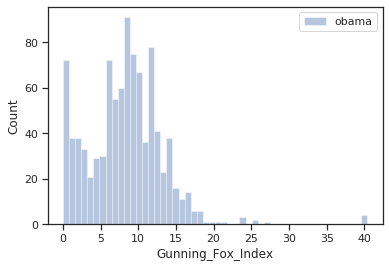

In [104]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set(style="ticks")

target_0 = df10p.loc[df10p['subreddit'] == topic]
# target_1 = df11p.loc[df11p['subreddit'] == topic2]

ax = sns.distplot(target_0[['Gunning_Fox_Index']], label=topic, hist=True, rug=False, kde=False, bins=50)
ax.set(xlabel='Gunning_Fox_Index', ylabel='Count')

plt.legend()


#### Flesch_Kincaid_Readability_ease for  -> Topic subreddit

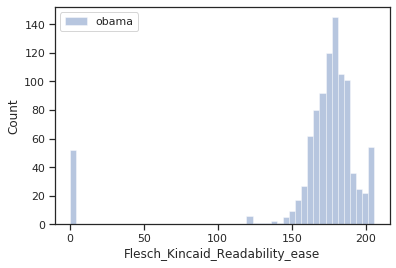

In [108]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set(style="ticks")

# df10p = df10.toPandas()
# df10p = df10p.dropna()

# Sort the dataframe by target
target_0 = df10p.loc[df10p['subreddit'] == topic]
# target_1 = df11p.loc[df11p['subreddit'] == topic2]

# sns.distplot(target_0[['Gunning_Fox_Index']], label="Gunning_Fox_Index", hist=True, rug=False)
ax = sns.distplot(target_0[['Flesch_Kincaid_Readability_ease']], label=topic, hist=True, rug=False, kde=False, bins=50)
# sns.distplot(target_0[['Flesch_Kincaid_GradeLevel']], label=Flesch_Kincaid_GradeLevel, hist=False, rug=False)

ax.set(xlabel='Flesch_Kincaid_Readability_ease', ylabel='Count')

plt.legend()
# plt.show()

#### Flesch_Kincaid_GradeLevel for  -> Topic subreddit

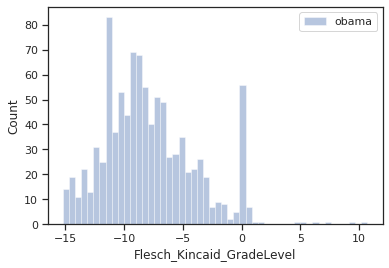

In [109]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set(style="ticks")

# df10p = df10.toPandas()
# df10p = df10p.dropna()

# Sort the dataframe by target
target_0 = df10p.loc[df10p['subreddit'] == topic]
# target_1 = df11p.loc[df11p['subreddit'] == topic2]

ax = sns.distplot(target_0[['Flesch_Kincaid_GradeLevel']], label=topic, hist=True, rug=False, kde=False, bins=50)

ax.set(xlabel='Flesch_Kincaid_GradeLevel', ylabel='Count')

plt.legend()
# plt.show()

### Choose 2 subreddits and compare the readability distribution

In [78]:
# topic1
# topic2

df11 = df8.select(df8.subreddit, df8.Gunning_Fox_Index, df8.Flesch_Kincaid_Readability_ease, df8.Flesch_Kincaid_GradeLevel).where(df8.subreddit.like(topic1) | df8.subreddit.like(topic2))

df11p = df11.toPandas()
df11p = df11p.dropna()


#### Comparing distribution of Gunning_Fox_Index for topic1 and Topic2

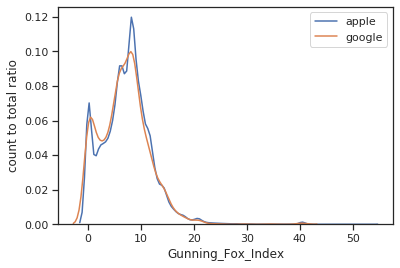

In [112]:
import seaborn as sns, numpy as np

sns.set(color_codes=True)
sns.set(style="ticks")

# Sort the dataframe by target
target_0 = df11p.loc[df11p['subreddit'] == topic1]
target_1 = df11p.loc[df11p['subreddit'] == topic2]

ax = sns.distplot(target_0[['Gunning_Fox_Index']], label=topic1, hist=False, rug=False)
ax = sns.distplot(target_1[['Gunning_Fox_Index']], label=topic2, hist=False, rug=False)

ax.set(xlabel='Gunning_Fox_Index', ylabel='count to total ratio')

plt.legend()
plt.show()


# import seaborn as sns, numpy as np
# import matplotlib.pyplot as plt

# sns.set(color_codes=True)
# sns.set(style="ticks")

# target_0 = df11p.loc[df11p['subreddit'] == topic1]
# target_1 = df11p.loc[df11p['subreddit'] == topic2]

# sns.distplot(target_0[['Gunning_Fox_Index']], label=topic1, hist=True, rug=False, kde=False, bins=50)
# sns.distplot(target_1[['Gunning_Fox_Index']], label=topic2, hist=True, rug=False, kde=False, bins=50)


# plt.legend()


#### Comparing distribution of Flesch_Kincaid_Readability_ease for topic1 and Topic2

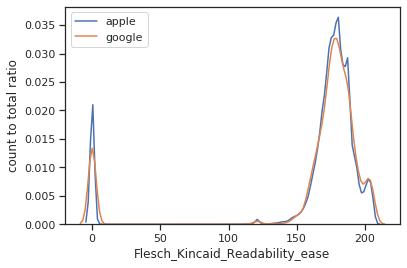

In [114]:
import seaborn as sns, numpy as np

sns.set(color_codes=True)
sns.set(style="ticks")



# Sort the dataframe by target
target_0 = df11p.loc[df11p['subreddit'] == topic1]
target_1 = df11p.loc[df11p['subreddit'] == topic2]
# target_2 = df11p.loc[df11p['subreddit'] == topic3]

ax = sns.distplot(target_0[['Flesch_Kincaid_Readability_ease']], label=topic1, hist=False, rug=False)
ax = sns.distplot(target_1[['Flesch_Kincaid_Readability_ease']], label=topic2, hist=False, rug=False)
# sns.distplot(target_2[['Flesch_Kincaid_Readability_ease']], label=topic3, hist=False, rug=False)

ax.set(xlabel='Flesch_Kincaid_Readability_ease', ylabel='count to total ratio')

plt.legend()
plt.show()


# import seaborn as sns, numpy as np
# import matplotlib.pyplot as plt

# sns.set(color_codes=True)
# sns.set(style="ticks")

# target_0 = df11p.loc[df11p['subreddit'] == topic1]
# target_1 = df11p.loc[df11p['subreddit'] == topic2]

# sns.distplot(target_0[['Flesch_Kincaid_Readability_ease']], label=topic1, hist=True, rug=False, kde=False, bins=50)
# sns.distplot(target_1[['Flesch_Kincaid_Readability_ease']], label=topic2, hist=True, rug=False, kde=False, bins=50)


# plt.legend()

#### Comparing distribution of Flesch_Kincaid_GradeLevel for topic1 and Topic2

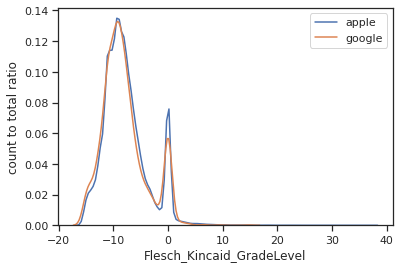

In [115]:
import seaborn as sns, numpy as np

sns.set(color_codes=True)
sns.set(style="ticks")



# Sort the dataframe by target
target_0 = df11p.loc[df11p['subreddit'] == topic1]
target_1 = df11p.loc[df11p['subreddit'] == topic2]
# target_2 = df11p.loc[df11p['subreddit'] == topic3]

ax = sns.distplot(target_0[['Flesch_Kincaid_GradeLevel']], label=topic1, hist=False, rug=False)
ax = sns.distplot(target_1[['Flesch_Kincaid_GradeLevel']], label=topic2, hist=False, rug=False)
# sns.distplot(target_2[['Flesch_Kincaid_GradeLevel']], label=topic3, hist=False, rug=False)

ax.set(xlabel='Flesch_Kincaid_GradeLevel', ylabel='count to total ratio')

plt.legend()
plt.show()


# import seaborn as sns, numpy as np
# import matplotlib.pyplot as plt

# sns.set(color_codes=True)
# sns.set(style="ticks")

# target_0 = df11p.loc[df11p['subreddit'] == topic1]
# target_1 = df11p.loc[df11p['subreddit'] == topic2]

# sns.distplot(target_0[['Flesch_Kincaid_GradeLevel']], label=topic1, hist=True, rug=False, kde=False, bins=50)
# sns.distplot(target_1[['Flesch_Kincaid_GradeLevel']], label=topic2, hist=True, rug=False, kde=False, bins=50)


# plt.legend()

#### Comparing all 3 readability with each other for subreddit -> Topic1 and Topic2

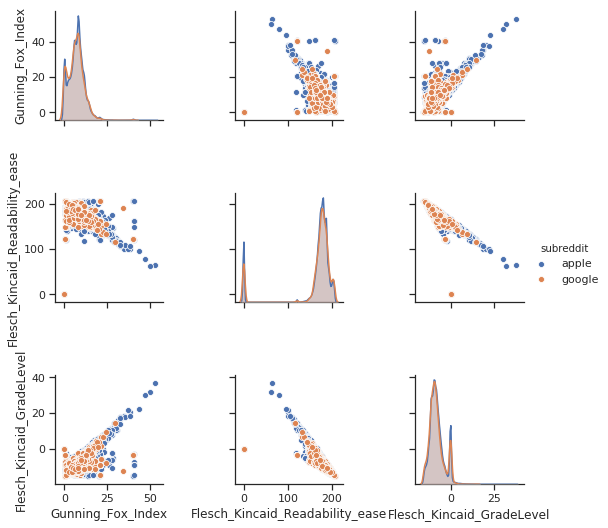

In [82]:
import seaborn as sns, numpy as np

sns.set(color_codes=True)
sns.set(style="ticks")

sns.pairplot(df11p, hue="subreddit")
plt.show()